In [204]:
%matplotlib inline

import numpy as np
from math import pi, sqrt
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import Akima1DInterpolator
from ipywidgets import interact

plt.style.use('ggplot')
plt.rcParams['font.size'] = 16.0

# Converging Diverging Nozzle

We will assume a calorically perfect, ideal gas.  We will also not include friction or heat transfer.  Thus, we will assume adiabatic flow.  

## Getting Started
Let's first set the specific heat ratio 
$$\gamma = \frac{c_p}{c_v}$$
We will set a default of 1.4 for air, and define some other variables for convenience.


In [205]:
g = 1.4
gp = g+1
gm = g-1

For convenience, we will define the function:
$$f(M) = M \left[ \frac{2}{\gamma + 1}\left( 1 + \frac{\gamma - 1}{2}M^2 \right)\right]^{\frac{-(\gamma+1)}{2(\gamma-1)}}$$
This is used in the area Mach relationship:
$$\frac{A^*}{A} = f(M)$$
Rather than working with the less physically relevant parameter $A^*$, we often replace it with $f(M) A $.  It is important to remember that $f(1) = 1$ as should be clear from its definition.

Our most important expression is conservation of mass.  Using the $f(M)$ function, conservation of mass can be expressed as:
$$\left( \frac{P_0 A f(M)}{\sqrt{T_0}}\right)_1 = \left( \frac{P_0 A f(M)}{\sqrt{T_0}}\right)_2$$
Because we are only concerend with adiabatic flows in this exercise, this is simplified to
$$( P_0 A f(M))_1 = ( P_0 A f(M))_2$$
for regions of isentropic flow this simplifes further to
$$A_1 f(M_1) = A_2 f(M_2)$$
Let's encapsulate $f(M)$ as a function so that we can reuse it for a given Mach number.

In [206]:
def fM(M):
    return M*(2.0/gp*(1 + gm/2.0*M**2))**(-gp/2.0/gm)

The equation cannot be analytic inverted.  Thus, if we know the area ratio $A^*/A$ solving for the corresponding Mach number requires a root finding approach:
$$froot(M) = \frac{A^*}{A} - f(M) = 0$$
Note that there are two solutions: a subsonic or a supersonic one and so we will also need to know which branch is sought.  We use brent's method for root finding.

In [207]:
def areaMach(Astar_A, speed):
    """returns Mach number associated with isentropic flow for a given area ratio and flow regime"""
    
    if speed=='subsonic':
        return brentq(lambda M: Astar_A - fM(M), 1e-6, 1.0)
    
    elif speed=='supersonic':
        return brentq(lambda M: Astar_A - fM(M), 1.0, 10.0)

We will also make heavy use of the isentropic relationships:
$$\frac{T_0}{T} = 1 + \frac{\gamma - 1}{2}M^2 $$
$$\frac{P_0}{P} = \left(\frac{T_0}{T}\right)^{\gamma/(\gamma-1)} $$
$$\frac{\rho_0}{\rho} = \left(\frac{T_0}{T}\right)^{1/(\gamma-1)} $$

In [208]:
def isenT(M):
    return 1 + gm/2.0*M**2

def isenP(M):
    return isenT(M)**(g/gm)

def isenrho(M):
    return isenT(M)**(1.0/gm)

These expressions can also be explictly inverted in order to solve for the Mach number given a known pressure, temperature, or density ratio.  We will only need the inverse pressure expression in this exercise.
$$ M = \sqrt{\frac{2}{\gamma -1} \left[\left(\frac{P_0}{P}\right)^{(\gamma-1)/\gamma} -1 \right]}$$

In [209]:
def isenM(P0_P):
    return sqrt(2.0/gm*(P0_P**(gm/g) - 1))

## Geometry

This is enough to get us started.  First we need to define the geometry that we want to solve.  We will define the radius at 5 locations along a unit length and fit an Akima spline in between.  The radii can be adjusted, but note that this simulation assumes a converging diverging nozzle so if you setup a different type of geometry the simulation may crash or the results will be nonsensical.

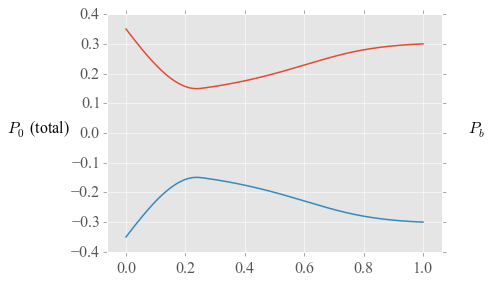

In [221]:
xpts = np.array([0, 0.25, 0.5, 0.75, 1.0])
rpts = np.array([0.35, 0.15, 0.20, 0.27, 0.3])
akima = Akima1DInterpolator(xpts, rpts)

n = 200
x = np.linspace(xpts[0], xpts[-1], n)
r = akima(x)

plt.figure()
plt.plot(x, r)
plt.plot(x, -r)
plt.axis('equal')
plt.text(1.15, 0, '$P_b$')
plt.text(-0.4, 0, '$P_0$ (total)')
plt.show()

With the geometry, defined we can now define some important quantities.

In [211]:
# area distribution
A = pi*r**2

# exit area
Ae = A[-1]

# area of throat, and corresponding index
ithroat = np.argmin(A)
Athroat = A[ithroat]

## Cases
There are a few discrete cases that each need to be considered separately, and conditions defined for when they occur: fully subsonic flow, standing shock wave, isentropic supersonic flow.  The parameter we will use that dictates the nozzle behavior is the ratio of the back pressure (downstream of the exit) to the total pressure (upstream of the entrance) $P_b/P_0$.  Note that the back pressure is not necessarily equal to the exit pressure (it is only equal if the exit is subsonic).  We will only focus on flow in the nozzle and thus, wont discuss the under- and overexpanded cases. When $P_b/P_0 = 1$ there is no flow.  As we lower the back pressure we will move through the various cases.

## Case I: fully subsonic
If the flow is everywhere subsonic, then under our assumptions it is also isentropic throughout.  As the back pressure is lowered, the flow will accelerate, but remain subsonic, until the limiting where the throat just reaches sonic conditions.  From a mass balance (isentropic) this limiting cases occurs at:
$$\begin{align}
A_{throat} &= A_e f(M_e)\\
\Rightarrow f(M_e) &= A_{throat}/A_e
\end{align}$$
We can now find the critical exit Mach number at which the throat just barely reaches sonic conditions and we still have subsonic flow throughout.  If the exit Mach number was any higher, we would no longer have fully subsonic flow.

In [212]:
# critical Mach number for subsonic flow throughout with sonic flow at throat
Me_crit_sub = areaMach(Athroat/Ae, 'subsonic')

If subsonic at the exit, the back pressure matches the exit pressure, and because the flow is isentropic the total pressure is constant throughout the nozzle.
$$\frac{P_b}{P_0} = \frac{P_e}{P_0}$$
We already know the critical exit Mach number and using the isentropic relationship, we can compute the corresponding critical pressure ratio for subsonic flow throughout.  As long as the pressure ratio $P_b/P_0$ is above this critical value, we will have subsonic flow throughout.

In [213]:
# corresponding critical pressure ratio
Pb_P0_crit_sub = 1.0/isenP(Me_crit_sub)

So if $$\frac{P_b}{P_0} > \left(\frac{P_b}{P_0}\right)_{crit-sub}$$ we will have subsonic flow through.  
We can evaluate the Mach number everywhere from the (isentropic) mass balance
$$\begin{align}
A\ f(M) &= A_e f(M_e)\\
f(M) &= \frac{A_e}{A} f(M_e)
\end{align}$$
where the Mach number at the exit is given by the isentropic relationship

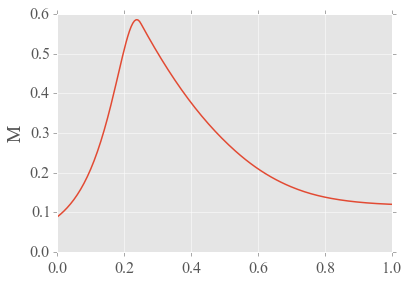

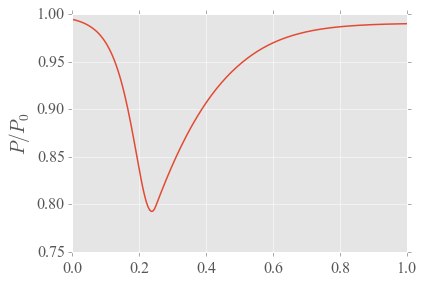

In [214]:
Pb_P0 = 0.99
M = np.zeros(n)

if Pb_P0 > Pb_P0_crit_sub:  # subsonic
    # back pressure equals exit pressure b.c. subsonic
    P0_Pe = 1.0/Pb_P0  
    
    # find exit Mach number from isentropic relationship
    Me = isenM(P0_Pe)
    
    # precompute f(Me) so we don't have to keep computing in the loop
    fMe = fM(Me)
    
    # iterate across all areas solving for the subsonic Mach number
    for i in range(n):
        M[i] = areaMach(Ae/A[i]*fMe, 'subsonic')
    
    # compute pressure distribution
    P_P0 = 1.0/isenP(M)


plt.figure()
plt.plot(x, M)
plt.ylabel('M')

plt.figure()
plt.plot(x, P_P0)
plt.ylabel('$P/P_0$')

# plt.figure()
# plt.plot(x, T_T0)
# plt.ylabel('$T/T_0$')

# plt.figure()
# plt.plot(x, rho_rho0)
# plt.ylabel('$\\rho/\\rho_0$')


plt.show()

## Case II: normal shock
As the back pressure decreases, the throat becomes chocked.  However, the back pressure is not yet low enough to permit isentropic supersonic flow through the back end of the nozzle and show a shock wave must be formed.  As the back pressure is decreased the shock wave moves further back along the nozzle until it is right at the exit. As the back pressure is decreased further we have supersonic flow throughout the back end of the nozzle. We must determine the critical pressure ratio that separates the case with a shock wave from the case with isentropic supersonic flow.

Computing this critical case is a little more work.  The limiting case has a shock wave right at the exit.  Thus, we need to find the Mach number behind a normal shock with isentropic supersonic flow all the way up to the exit.  From the normal shock equations we can compute the Mach number behind the shock wave as:
$$M_2 = \sqrt{\frac{2 + (\gamma-1)M_1^2}{2\gamma M_1^2 - (\gamma-1)}}$$

In [215]:
def shockM(M1):
    """computes the mach number behind a normal shock"""
    return sqrt((2 + gm*M1**2)/(2*g*M1**2 - gm))

Thus, with a shock wave standing right at the exit the Mach number right behind the shock is:

In [216]:
# Mach number ahead of shock right before exit
Me_up = areaMach(Athroat/Ae, 'supersonic')

# Mach number at exit (downstream of shock)
Me = shockM(Me_up)

We now need to determine the total pressure loss across the shock wave, so we can figure out the pressure ratio across the nozzle.  Using a mass balance from the throat to exit:
$$
\begin{align}
( P_0 A f(M))_t &= ( P_0 A f(M))_e\\
{P_0}_t A_t  &= {P_0}_e A_e f(M_e)\\
\Rightarrow \frac{{P_0}_e}{{P_0}_t} f(M_e) &= \frac{A_t}{A_e}\\
\frac{{P_0}_e}{P_e}\frac{P_e}{{P_0}_t} f(M_e)&=\frac{A_t}{A_e}\\
\Rightarrow \frac{{P_0}_t}{P_e} &=\frac{{P_0}_e}{P_e} f(M_e)\frac{A_e}{A_t}\\
\end{align}
$$
Because there is a shock wave, the exit pressure is again equal to the back pressure ($P_e = P_b$).  Also, because there is no shock wave between the throat at the entrance, $P_0 = {P_0}_t$.  Thus, the critcal pressure ratio is:
$$\frac{P_b}{P_0} =\frac{P_e}{{P_0}_e} \frac{1}{f(M_e)}\frac{A_t}{A_e}$$

In [217]:
# corresponding critical pressure ratio
Pb_P0_crit_super = Athroat/(isenP(Me)*fM(Me)*Ae)

As long as the pressure is above this critical value, a shock wave will exist in the throat.  This case is a bit more difficult if we want to find the location of the shock.  First we must solve for the exit Mach number using the above mass balance.  However, there is no explicit solution so we must again use a root finding technique:
$$froot(M_e) = f(M_e) \frac{{P_0}_e}{P_e} - \frac{P_0}{P_b}\frac{A_t}{A_e} = 0$$

Once we know the exit Mach number we can find the total pressure loss across the shock using the equation above and repeated here:
$$\frac{{P_0}_e}{{P_0}_t}  = \frac{A_t}{A_e}\frac{1}{f(M_e)}$$

If we know the total pressure loss across the shock, then we know the upstream Mach number from the normal Mach equations (and also the downstream Mach number).
$$\frac{{P_0}_2}{{P_0}_1} = \left(\frac{\gamma +1}{2 \gamma M_1^2 - (\gamma - 1)}\right)^{\frac{1}{\gamma-1}}   \left( \frac{(\gamma + 1) M_1^2}{2 + (\gamma - 1) M_1^2}\right)^{\frac{\gamma}{\gamma-1}}$$
To solve this for $M_1$ requires a root finding method

Using conservation of mass from just behind the shock to the exit (isentropic) allows us to compute the area of where the shock sits:
$$\begin{align}
A_s f(M_s) &= A_e f(M_e) \\
A_s  &= A_e \frac{f(M_e)}{f(M_s)}
\end{align}$$

With a known shock location we can use a mass balance from the entrance to just before the shock (subsonic solution up to throat, supersonic solution after throat).
$$\begin{align}
A f(M) &= A_t \\
f(M) &= \frac{A_t}{A}
\end{align}$$
and after the shock:
$$\begin{align}
A f(M) &= A_e f(M_e) \\
f(M) &= \frac{A_e}{A} f(M_e)
\end{align}$$

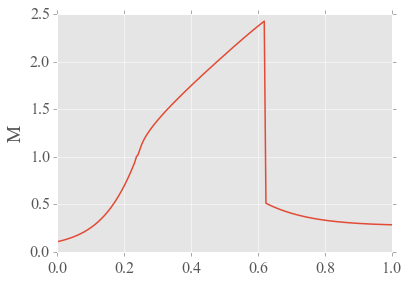

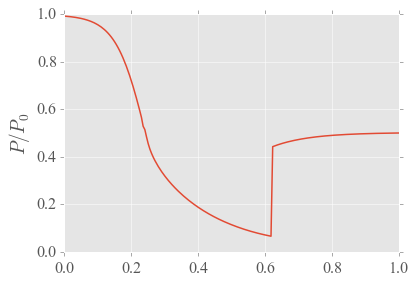

In [218]:
Pb_P0 = 0.5

if Pb_P0 > Pb_P0_crit_super:  # shock in nozzle

    # exit Mach number
    Me = brentq(lambda M: fM(M)*isenP(M) - Athroat/Ae/Pb_P0, 1e-6, 1.0)
    
    # total pressure loss across shock
    P0e_P0t = Athroat/Ae/fM(Me)
    
    # Mach number ahead of shock
    Mup = brentq(lambda M: P0e_P0t - (gp/(2*g*M**2 - gm))**(1.0/gm)*(gp*M**2/(2 + gm*M**2))**(g/gm), 1.0, 10.0)
    
    # Mach number after shock
    Mdown = shockM(Mup)
    
    # area at shock location
    As = Ae*fM(Me)/fM(Mdown)
    
    # find closest corresponding index of shock (must be aft of throat)
    ishock = np.argwhere(A[ithroat:] >= As)[0][0]
    ishock += ithroat
    
    # solution up to shock
    for i in range(ithroat):
        M[i] = areaMach(Athroat/A[i], 'subsonic')
    for i in range(ithroat, ishock):
        M[i] = areaMach(Athroat/A[i], 'supersonic')
        
    # solution after shock
    fMe = fM(Me)
    for i in range(ishock, n):
        M[i] = areaMach(Ae/A[i]*fMe, 'subsonic')

    # isentropic pressure
    P_P0 = 1.0/isenP(M)
    
    # add additional pressure loss of shock
    P_P0[ishock:] *= P0e_P0t

plt.figure()
plt.plot(x, M)
plt.ylabel('M')

plt.figure()
plt.plot(x, P_P0)
plt.ylabel('$P/P_0$')

plt.show()

## Case III: isentropic supersonic flow

The last case is relatively simple.  Choked flow with isentropic flow aft of the nozzle exit.  The exit Mach number is supersonic and thus the exit mach number and the back pressure Mach number need not agree.  When the back pressure is reduced below the previous case, but is still larger than the exit pressure the nozzle is overexpanded and oblique shocks wil exist outside of the nozzle to converge the flow and increase the pressure to match the back pressure.

Conversely, if the back pressure is reduced below the exit pressure then the nozzle is underexpanded and expansion waves will exist outside of the nozzle to expand the flow and decrease the pressure to match the back pressure.

If they back pressure and the exit pressure match perfectly, then the nozzle is ideally expanded.

overexpanded


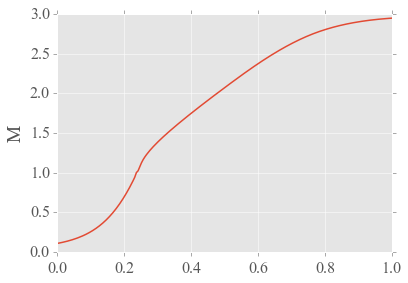

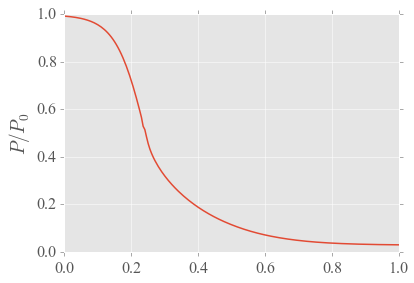

In [219]:
Pb_P0 = 0.2

for i in range(ithroat):
    M[i] = areaMach(Athroat/A[i], 'subsonic')
for i in range(ithroat, n):
    M[i] = areaMach(Athroat/A[i], 'supersonic')

P_P0 = 1.0/isenP(M)

Pe_P0 = P_P0[-1]

if Pb_P0 > Pe_P0:
    print 'overexpanded'
elif Pb_P0 == Pe_P0:
    print 'ideally expanded'
else:
    print 'underexpanded'

plt.figure()
plt.plot(x, M)
plt.ylabel('M')

plt.figure()
plt.plot(x, P_P0)
plt.ylabel('$P/P_0$')

plt.show()


## Interactive

Let's now combine all the cases into one simulation

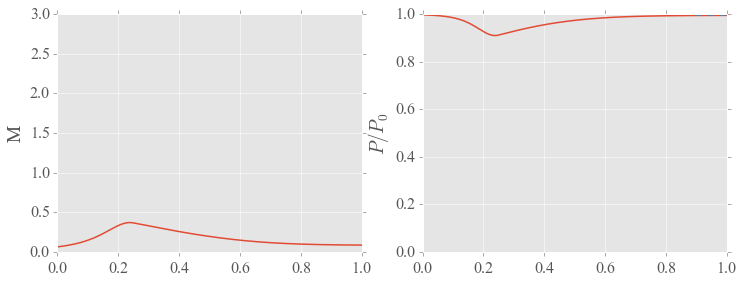

None

In [220]:
# an interactive version where you can change the back pressure
# this will not run on nbviewer.  You can view it locally if
# you've installed Jupyter notebook or upload to http://try.jupyter.org

@interact(Pb_P0=(0, 0.995, 0.005))
def nozzle(Pb_P0=0.995):
    
    M = np.zeros(n)

    if Pb_P0 > Pb_P0_crit_sub:  # subsonic

        # back pressure equals exit pressure b.c. subsonic
        P0_Pe = 1.0/Pb_P0  

        # find exit Mach number from isentropic relationship
        Me = isenM(P0_Pe)

        # precompute f(Me) so we don't have to keep computing in the loop
        fMe = fM(Me)

        # iterate across all areas solving for the subsonic Mach number
        for i in range(n):
            M[i] = areaMach(Ae/A[i]*fMe, 'subsonic')

        # compute pressure distribution
        P_P0 = 1.0/isenP(M)

    elif Pb_P0 > Pb_P0_crit_super:  # shock in nozzle

        # exit Mach number
        Me = brentq(lambda M: fM(M)*isenP(M) - Athroat/Ae/Pb_P0, 1e-6, 1.0)

        # total pressure loss across shock
        P0e_P0t = Athroat/Ae/fM(Me)

        # Mach number ahead of shock
        Mup = brentq(lambda M: P0e_P0t - (gp/(2*g*M**2 - gm))**(1.0/gm)*(gp*M**2/(2 + gm*M**2))**(g/gm), 1.0, 10.0)

        # Mach number after shock
        Mdown = shockM(Mup)

        # area at shock location
        As = Ae*fM(Me)/fM(Mdown)

        # find closest corresponding index of shock (must be aft of throat)
        ishock = np.argwhere(A[ithroat:] >= As)[0][0]
        ishock += ithroat

        # solution up to shock
        for i in range(ithroat):
            M[i] = areaMach(Athroat/A[i], 'subsonic')
        for i in range(ithroat, ishock):
            M[i] = areaMach(Athroat/A[i], 'supersonic')

        # solution after shock
        fMe = fM(Me)
        for i in range(ishock, n):
            M[i] = areaMach(Ae/A[i]*fMe, 'subsonic')

        # isentropic pressure
        P_P0 = 1.0/isenP(M)

        # add additional pressure loss of shock
        P_P0[ishock:] *= P0e_P0t

    else:

        for i in range(ithroat):
            M[i] = areaMach(Athroat/A[i], 'subsonic')
        for i in range(ithroat, n):
            M[i] = areaMach(Athroat/A[i], 'supersonic')

        P_P0 = 1.0/isenP(M)

        Pe_P0 = P_P0[-1]

#         if Pb_P0 > Pe_P0:
#             print 'overexpanded'
#         elif Pb_P0 == Pe_P0:
#             print 'ideally expanded'
#         else:
#             print 'underexpanded'
            
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(x, M)
    plt.ylim([0, 3])
    plt.ylabel('M')

    plt.subplot(1,2,2)
    plt.plot(x, P_P0)
    plt.plot([0.9, 1.0], [Pb_P0, Pb_P0], '--')
    plt.ylim([0, 1])
    plt.ylabel('$P/P_0$')
    
    plt.show()
